In [10]:
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import glob, os, sys

import gensim
from gensim import models,corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt

%matplotlib inline
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'
pyLDAvis.enable_notebook()

In [3]:
HTML(
    '''<script>
            code_show=true; function code_toggle() { 
            if (code_show){ $('div.input').hide(); 
            } else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle); 
        </script>
<br>Clique <a href="javascript:code_toggle()">aqui</a> para mostrar o código.''')

Este relatório desenvolve uma aplicação de processamento de linguagem natural, com o objetivo de extrair conhecimento sobre a percepção dos clientes sobre o serviço prestado por um aplicativo de entregas, a Shipp Delivery.

Para atingir este resultado, foi aplicado um algoritmo para modelagem de tópicos (Latent Dirichlet Allocation - LDA) nos comentários sobre o aplicativo disponíveis na Google Play Store entre 2018 e 2019.

Foram coletados, em HTML bruto, aproximandamente 1100 comentários. Os dados, disponíveis no arquivo "comentarios.txt" foram tratados com o script "word_token.py".

A tabela abaixo mostra uma sumarização do que foi obtido de relavante para a análise proposta.

In [26]:
df = pd.read_csv('tabela_comentario.csv', encoding='utf-16').dropna()
df[['nome', 'aval', 'data', 'lemma']]

,nome,aval,data,lemma
0,Carolina Scopel,5,14/11/2019,amo app nao conseguindo utiliza-lo deslogou na...
1,deborah Domingues,2,13/11/2019,transtorno atras transtorno unica vantagem shi...
2,Henrique Silva,3,10/12/2019,app bom porem nao consigo fazer pedidos cidade...
3,Vitor Bastos,2,23/10/2019,servico shipp bom app trava constantemente fic...
4,Túlio Soares Mariante,1,7/11/2019,primeira copra app loja basque avisado colocas...
...,...,...,...,...
1037,samuel xavier,5,29/4/2018,otimo app
1038,Paola da Costa,1,23/10/2019,nao gostei
1039,nao Sei,5,16/11/2019,app maravilhoso
1040,Moto Filmador,5,16/5/2018,bom


In [27]:
# Criando Dicionario
coments = [d.split() for d in df['lemma']]
id2word = corpora.Dictionary(coments)

# criando vetores das palavras
vec_coment = [id2word.doc2bow(coment) for coment in coments]

In [28]:
def cv(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
model_list, coherence_values = cv(dictionary=id2word, corpus=vec_coment, texts=coments, start=1, limit=20, step=1)

Grafico

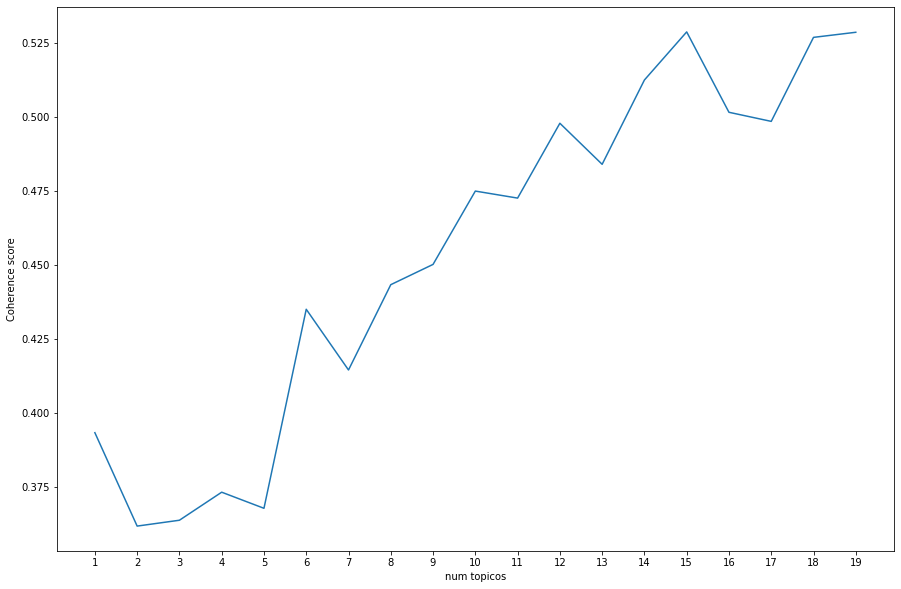

In [30]:
# Show graph
limit=20; start=1; step=1;

x = range(start, limit, step)

plt.plot(x, coherence_values)

plt.rcParams["figure.figsize"] = [15,10]

plt.xlabel("num topicos")
plt.ylabel("Coherence score")
plt.xticks(range(1, 20))
plt.show()

Topicos

Visualização com 4 Tópicos

In [42]:
best_model = model_list[5]
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(best_model)

# Visualize the topics
vis = pyLDAvis.gensim.prepare(model, vec_coment, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.216910 -0.019800       1        1  16.981224
5     -0.214469 -0.064790       2        1  16.919410
1     -0.213427 -0.092077       3        1  16.783061
3      0.284937 -0.141749       4        1  16.655346
4      0.274768 -0.129435       5        1  16.451554
0      0.085100  0.447851       6        1  16.209405, topic_info=     Category        Freq     Term       Total  loglift  logprob
4     Default  387.000000      app  387.000000  30.0000  30.0000
20    Default  459.000000      nao  459.000000  29.0000  29.0000
58    Default  145.000000      bom  145.000000  28.0000  28.0000
37    Default  123.000000  entrega  123.000000  27.0000  27.0000
100   Default  100.000000   pedido  100.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
130    Topic6    4.871034     nova    4.871034   1.8196  -5.5475
1114   Topic6    4.871034    baixa    4.871034   1.8196  -5.5475
51     Topic6   25.329375    tempo   29.388829   1.6709  -3.8989
361    Topic6    7.793654    preco    9.883713   1.5820  -5.0775
510    Topic6    5.845240     casa   13.964148   0.9487  -5.3652

[401 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
941       3  0.991391           abc
608       2  1.007929          abre
0         2  1.007929          abro
806       6  1.026476  absurdamente
667       2  1.007929          acai
...     ...       ...           ...
701       2  1.007929         vinte
1125      5  0.985354       vitoria
724       1  0.956911          voce
504       2  1.007929        voltou
226       2  1.007929           vou

[394 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 2, 4, 5, 1])

O indicador de Coherence reporta valores maiores para tópicos mais humanamente interpretáveis(1,2)

Porém, apesar de o Coherence Value ir aumentando com a quantidade de tópicos neste exercício, eles acabam se aglutinando em três áreas bem demarcadas, como mostra a visualização abaixo, com 15 tópicos.

In [36]:
second_best_model = model_list[16]
second_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(second_best_model)

# Visualize the topics
vis = pyLDAvis.gensim.prepare(second_model, vec_coment, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8      0.324617 -0.126772       1        1  6.103475
11     0.320896 -0.147751       2        1  6.100862
7      0.010512  0.156834       3        1  6.074731
14    -0.142249 -0.075016       4        1  6.043113
5      0.001592  0.153405       5        1  6.030824
15     0.327242 -0.156595       6        1  5.942102
13     0.032384  0.159957       7        1  5.938443
6     -0.224679 -0.193000       8        1  5.904921
2     -0.123122 -0.078047       9        1  5.898926
9     -0.004441  0.046928      10        1  5.870383
16     0.004923  0.201056      11        1  5.833225
1     -0.226673 -0.161481      12        1  5.825481
3     -0.062604  0.001874      13        1  5.805426
10    -0.036309  0.112402      14        1  5.787462
12    -0.183900 -0.206314      15        1  5.756255
4     -0.027254  0.134001      16        1  5.624110
0      0.009066  0.178519      17        1  5.460261, topic_info=     Category        Freq      Term       Total  loglift  logprob
20    Default  444.000000       nao  444.000000  30.0000  30.0000
4     Default  394.000000       app  394.000000  29.0000  29.0000
58    Default  158.000000       bom  158.000000  28.0000  28.0000
37    Default  125.000000   entrega  125.000000  27.0000  27.0000
100   Default  104.000000    pedido  104.000000  26.0000  26.0000
...       ...         ...       ...         ...      ...      ...
62    Topic17    4.252937  entregas   14.717632   1.6662  -4.5951
564   Topic17    3.189703    demais    9.382160   1.8288  -4.8828
424   Topic17    2.126468   poderia    4.170104   2.2342  -5.2883
201   Topic17    2.126468   pratico   16.026312   0.8879  -5.2883
1482  Topic17    2.126468  bernardo    4.076740   2.2568  -5.2883

[1170 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
474       2  1.067092      -se
1354      3  1.043929      aba
488       8  0.957550   abaixo
941       5  1.025725      abc
608       8  0.231234     abre
...     ...       ...      ...
317       5  1.025725   voltar
226       2  0.123262      vou
226      15  0.862837      vou
106       9  1.002493  voucher
2018     13  0.860035    zuado

[1278 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 12, 8, 15, 6, 16, 14, 7, 3, 10, 17, 2, 4, 11, 13, 5, 1])